# 01_data_processing
Load downcore data, apply age models, and convert SS data.

This notebooks outputs the following figures:
- SF1: Age Models
- SF2: APcomp SS continuity 
- SF3: Flow speed conversion
- SF4: Carbon isotope gradient records

In [1]:
cd '/Users/starr/My Drive/Files/Projects/U1475/subproject_repos/SS_Paper/Starr_etal_ACC'

/Users/starr/My Drive/Files/Projects/U1475/subproject_repos/SS_Paper/Starr_etal_ACC


In [2]:
# PREAMBLE - import dependencies
import numpy as np
import matplotlib as mpl
import pandas as pd
import matplotlib.gridspec as gridspec

from matplotlib import pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from scipy.interpolate import interp1d
from scipy.interpolate import PchipInterpolator
from scipy.stats import sem
from scipy import signal
from statsmodels.nonparametric.smoothers_lowess import lowess as sm_lowess
from scipy.ndimage import gaussian_filter1d
from scipy.stats import shapiro

# plotting style
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams['font.size'] = 10
mpl.rcParams["mathtext.fontset"] = "dejavusans"

In [3]:
### APcomp data
apcomp = pd.read_csv('data/APcomp/apcomp_raw.csv')
apcomp.drop(columns=apcomp.columns[0],inplace=True)
apcomp.describe().transpose()

### MD02-2588 raw SS data for overlap figure
md022588 = pd.read_csv('data/APcomp/MD02_2588_data.csv')
u1475 = pd.read_csv('data/APcomp/U1475_splice_data.csv')

## Age Model
- Use the LR04 Age Model from [Starr et al., 2021](https://www.nature.com/articles/s41586-020-03094-7)
- load and apply to `apcomp` dataframe

In [4]:
### define age_model function
def age_model(depth_in,ties):
    f = interp1d(ties.iloc[:,0],ties.iloc[:,1],fill_value='extrapolate')
    age = f(depth_in)
    return age
    
## load LR04 age model
lr04_age_model = pd.read_csv('data/APcomp/u1475_lr04_age_model.csv')
ties = lr04_age_model[['APcomp Depth','Age (kyr)']]
apcomp['LR04_age'] = age_model(apcomp['APcomp Depth (m)'],ties)

## plot LR04 and APcomp to check age model quality
fileurl = 'https://raw.githubusercontent.com/gibbs-hmm/HMM-Match/master/Prob_stack.txt' # pull prob-stack from the HMM-Stack github repo
prob = pd.read_csv(fileurl,header=None,sep='  ')

/var/folders/c_/cgbnj8n943z0v0kv5qjmw2s00000gn/T/ipykernel_80862/804943069.py:14: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  prob = pd.read_csv(fileurl,header=None,sep='  ')


----
## Drake Passage record(s)
- PS97/085 SS record from [Wu et al., 2021](https://www.nature.com/articles/s41467-021-24264-9)
- PS97/093 SS and XRF record from [Toyos et al., 2020](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019PA003773)

In [6]:
##ps97/093
ps97_093_xrf = pd.read_excel('data/external_data.xlsx',sheet_name='PS97_097_xrf',header=12)
ps97_093_ss = pd.read_excel('data/external_data.xlsx',sheet_name='PS97_097_SS',header=8)
ps97_085_ss = pd.read_excel('data/external_data.xlsx',sheet_name='PS97_085',header=10)
ps97_093_xrf.head(2)

,Depth [m],Age (Toyos 2019) [kyr],Revised Age [kyr[,Ca [cts],Fe [cts],Ti [cts],K [cts],Zr/Rb
0,0.005,4.160000,4.160000,267946.8,27148.4,6682.8,6211.57,4.01
1,0.010,4.402128,4.402128,267946.8,27148.4,6682.8,6211.57,4.01


----
## South Pacific (Lamy)
- U1540 record from [Lamy et al 2024](https://www.nature.com/articles/s41586-024-07143-3)
- U1541 record from [Lamy et al 2024](https://www.nature.com/articles/s41586-024-07143-3)
- U1541 d18O record from [Middleton et al., 2024](https://gchron.copernicus.org/articles/6/125/2024)

In [13]:
u1540 = pd.read_excel('data/external_data.xlsx',sheet_name='U1540',header=20)
u1541 = pd.read_excel('data/external_data.xlsx',sheet_name='U1541',header=20)
u1541_d18o = pd.read_excel('data/external_data.xlsx',sheet_name='U1541_d18O',header=25)
u1541_d18o.head(2)

,Event,Sample label (DSDP/ODP/IODP sample designation),Sect [cm] (Bottom depth),Depth sed [m] (Top Depth - CSF-A depth scale...),Depth sed [m] (Top Depth - CCSF depth scale ...),Data source,Cibicidoides spp. δ18O [‰ PDB] (Average Cibicidoides spp d18O...),"Age model [ka] (Output age, Hidden Markov Mod...)",Age model [ka] (95% Confidence Upper Age Limi...),Age model [ka] (95% Confidence Lower Age Limi...)
0,383-U1541C,"383-U1541C-1H-1,0-1",1.0,0.00,0.00,Middleton et al. (2024),2.88,0.0,0.3,0.0
1,383-U1541C,"383-U1541C-1H-1,5-6",6.0,0.05,0.05,Middleton et al. (2024),3.03,1.4,3.4,0.5


----
## MD02-2589
- MD02-2589 record from the Agulhas Plateau, (from [Molyneux et al., 2007](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2006PA001407))


In [8]:
md02_2589 = pd.read_excel('data/external_data.xlsx',sheet_name='MD02_2589',header=8)
md02_2589.head(2)

,Depth [cm],Corrected Depth [cm],Age [kyr],Mean Sortable Silt [um]
0,1,1,11.610383,18.72
1,2,2,11.619514,20.48


----
## ODP site 1123
- ODP 1123 SS record from [Hall et al., 2001](https://www.nature.com/articles/35090552);
- ODP 1123 benthic isotope record from [Elderfield et al., 2012](https://www.science.org/doi/full/10.1126/science.1221294);

In [9]:
odp1123_ss = pd.read_excel('data/external_data.xlsx',sheet_name='ODP1123_SS',header=8)
odp1123_ss['SS_mean'] = pd.to_numeric(odp1123_ss['SS_mean'],errors='coerce')
odp1123_isotopes = pd.read_excel('data/external_data.xlsx',sheet_name='ODP1123_isotopes',header=11)
odp1123_isotopes.head(2)

,Sample label,Depth sed [m],Depth comp [mcd],Depth comp r [rmcd],Age [ka BP],Uvigerina spp. δ18O [‰ PDB],Uvigerina spp. δ13C [‰ PDB],Mg/Ca [mmol/mol]
0,"181-1123C-1H-1,3-5",0.03,0.03,0.03,7.0,3.40,-0.28,1.140
1,"181-1123C-1H-1,9-11",0.09,0.09,0.09,8.1,3.33,-0.27,1.158


----
## Supplementary Figure 1: Age Models

<>:13: SyntaxWarning: invalid escape sequence '\m'
<>:13: SyntaxWarning: invalid escape sequence '\m'
/var/folders/c_/cgbnj8n943z0v0kv5qjmw2s00000gn/T/ipykernel_80862/3556380964.py:13: SyntaxWarning: invalid escape sequence '\m'
  a.set_ylabel('$\mathrm{\delta^{18}O_{benthic}\ (^o/_{oo})}$')


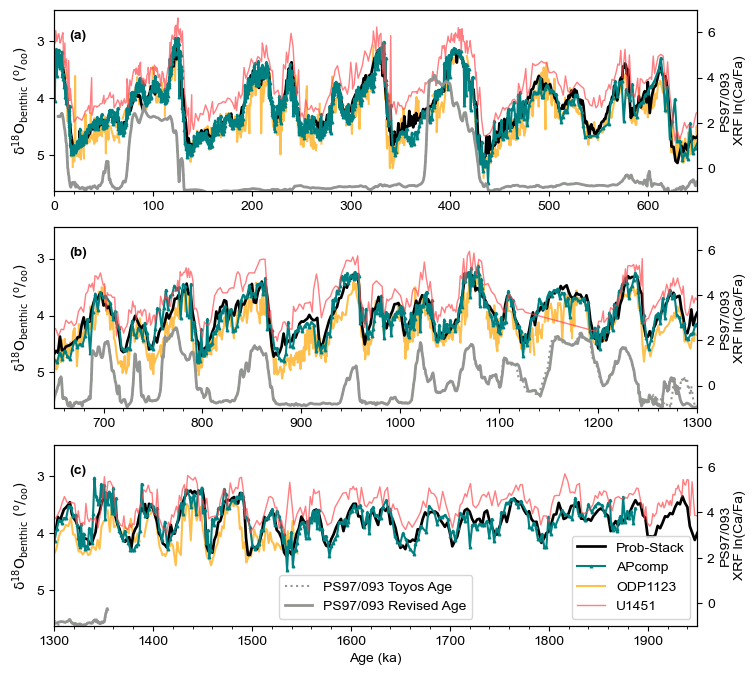

In [20]:
####### plot
f,ax = plt.subplots(3,1,figsize=(7,9))

for a in ax:
    a.plot(prob[0],prob[1],label='Prob-Stack',color='k',lw=1.95)
    n = apcomp['Cwu d18O (VPDB)'].notnull()
    a.plot(apcomp['LR04_age'][n],apcomp['Cwu d18O (VPDB)'][n]+0.43,label='APcomp',color='teal',marker='^',ms=1.85,lw=1.5)
    a.plot(odp1123_isotopes['Age [ka BP]'][n],odp1123_isotopes['Uvigerina spp. δ18O [‰ PDB]'][n],label='ODP1123',color='orange',marker='^',ms=0,lw=1.5,zorder=-1,alpha=0.7)

    a.plot(u1541_d18o['Age model [ka] (Output age, Hidden Markov Mod...)'],u1541_d18o['Cibicidoides spp. δ18O [‰ PDB] (Average Cibicidoides spp d18O...)'],lw=1,color='xkcd:light red',alpha=0.7,label='U1451')

    a.invert_yaxis()
    a.set_ylabel('$\mathrm{\delta^{18}O_{benthic}\ (^o/_{oo})}$')
    a.xaxis.set_minor_locator(MultipleLocator(20))

    a1 = a.twinx()
    a1.plot(ps97_093_xrf['Age (Toyos 2019) [kyr]'],np.log(ps97_093_xrf['Ca [cts]']/ps97_093_xrf['Fe [cts]']),color='xkcd:grey',lw=1.5,label='PS97/093 Toyos Age',linestyle=':')
    a1.plot(ps97_093_xrf['Revised Age [kyr['],np.log(ps97_093_xrf['Ca [cts]']/ps97_093_xrf['Fe [cts]']),color='xkcd:grey',lw=2,label='PS97/093 Revised Age')
    a1.set_ylim(-1,7)
    a1.set_ylabel('PS97/093\nXRF ln(Ca/Fa)')
    
    
ax[0].set_xlim(0,650)
ax[1].set_xlim(650,1300)
ax[2].set_xlim(1300,1950)
ax[2].legend(loc='lower right')   
a1.legend(loc='lower center')
ax[-1].set_xlabel('Age (ka)')
#ax[2].text(1370,5.4,'PS97/093 Toyos 2019 Age Model',color='xkcd:dark grey',fontweight='bold')
f.set_size_inches(8.3,8)

for p,a in zip(['(a)','(b)','(c)'],ax):
    a.text(a.get_xlim()[0]+15,2.95,p,fontweight='bold')


plt.savefig('figures/SF1_Age_Models.pdf',bbox_inches='tight')

----
## Clean and Confidence Intervals SS
#### Combining MD02-2588 and Site U1475

<>:16: SyntaxWarning: invalid escape sequence '\m'
<>:16: SyntaxWarning: invalid escape sequence '\m'
/var/folders/c_/cgbnj8n943z0v0kv5qjmw2s00000gn/T/ipykernel_80862/721329093.py:16: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('$\mathrm{\overline{SS}\ (\mu m)}$')


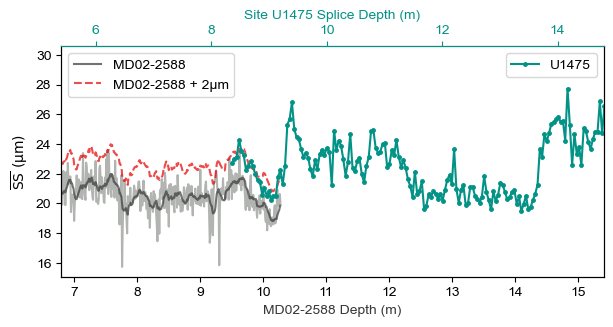

In [21]:
fig = plt.figure(figsize=(7,3))
ax = fig.add_subplot(1,1,1)
ax1 = ax.twiny()

n = md022588['SS mean'].notnull()
ax.plot(md022588['Depth (m)'][n]/100,md022588['SS mean'][n],color='xkcd:grey',alpha=0.7)
ax.plot(md022588['Depth (m)'][n]/100,md022588['SS mean'][n].rolling(10).mean(),color='xkcd:dark grey',alpha=0.7,label='MD02-2588')

ax.plot(md022588['Depth (m)'][n]/100,md022588['SS mean'][n].rolling(10).mean()+2,color='xkcd:red',alpha=0.7,linestyle='--',label='MD02-2588 + 2µm')

ax1.plot(u1475['Mid depth CCSF-361-U1475-BCDEF-20160305 (m)'],u1475['SS mean'],color='xkcd:teal',marker='o',ms=2.5,label='U1475')

ax.set_xlim(6.8,15.4)
ax1.set_xlim(5.4,14.8)

ax.set_ylabel('$\mathrm{\overline{SS}\ (\mu m)}$')
ax.set_xlabel('MD02-2588 Depth (m)',color='xkcd:dark grey')
ax1.set_xlabel('Site U1475 Splice Depth (m)',color='xkcd:teal')
ax1.tick_params(axis='x', colors='xkcd:teal')  
ax1.spines['top'].set_color('xkcd:teal')

ax1.legend()
ax.legend(loc='upper left')

plt.savefig('figures/SF2_splice.pdf',bbox_inches='tight')

<>:50: SyntaxWarning: invalid escape sequence '\m'
<>:51: SyntaxWarning: invalid escape sequence '\m'
<>:52: SyntaxWarning: invalid escape sequence '\m'
<>:53: SyntaxWarning: invalid escape sequence '\m'
<>:50: SyntaxWarning: invalid escape sequence '\m'
<>:51: SyntaxWarning: invalid escape sequence '\m'
<>:52: SyntaxWarning: invalid escape sequence '\m'
<>:53: SyntaxWarning: invalid escape sequence '\m'
/var/folders/c_/cgbnj8n943z0v0kv5qjmw2s00000gn/T/ipykernel_80862/344313910.py:50: SyntaxWarning: invalid escape sequence '\m'
  ax[0].set_ylabel('$\mathrm{\overline{SS}\ (\mu m)}$')
/var/folders/c_/cgbnj8n943z0v0kv5qjmw2s00000gn/T/ipykernel_80862/344313910.py:51: SyntaxWarning: invalid escape sequence '\m'
  ax[1].set_ylabel('$\mathrm{\overline{SS}_{unit-variance}}$')
/var/folders/c_/cgbnj8n943z0v0kv5qjmw2s00000gn/T/ipykernel_80862/344313910.py:52: SyntaxWarning: invalid escape sequence '\m'
  ax[2].set_ylabel('$\mathrm{\overline{SS}_{\Delta Holocene}\ (\mu m)}$')
/var/folders/c_/cgbnj

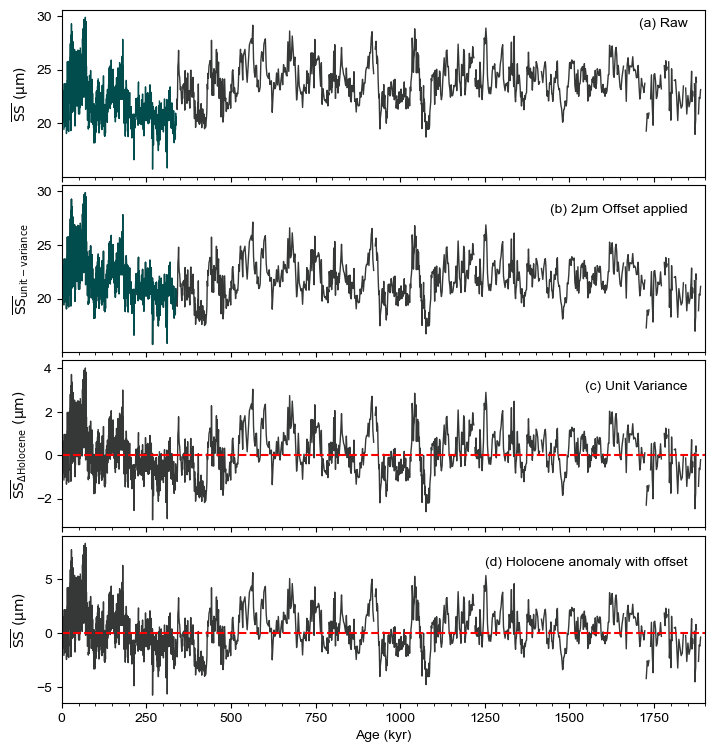

In [22]:
SS_holocene = apcomp[apcomp['LR04_age']<7]['SS mean'].mean()

split = 10.313 # depth at which the apcomp switches to U1475
md_ss = apcomp[apcomp['APcomp Depth (m)']<split]['SS mean']
u_ss = apcomp[apcomp['APcomp Depth (m)']>=split]['SS mean']

### UNIT VARIANCE
md_ss = (md_ss - md_ss.mean())/(md_ss.std()) # z-score standardize the data seperately
u_ss = (u_ss - u_ss.mean())/(u_ss.std())
ss_unit = np.concatenate([md_ss,u_ss])
apcomp['SS_unitv'] = ss_unit # recombine

### Holocene anomaly
md_ss = apcomp[apcomp['APcomp Depth (m)']<split]['SS mean']
u_ss = apcomp[apcomp['APcomp Depth (m)']>=split]['SS mean']
md_ss = md_ss-SS_holocene  # anomaly from Holocene value
u_ss = u_ss-2-SS_holocene  # anomaly from Holcoene value + 2um to account for Md02-2588 - U1475 offset of 2um
ss_dHolocene = np.concatenate([md_ss,u_ss])
apcomp['SS_dHolocene'] = ss_dHolocene

### Offset
md_ss = apcomp[apcomp['APcomp Depth (m)']<split]['SS mean']
u_ss = apcomp[apcomp['APcomp Depth (m)']>=split]['SS mean']
ss_offset = np.concatenate([md_ss,u_ss-2])

apcomp['SS_offset'] = ss_offset # include the offset alternative for posterity 

###### plot results

f,ax = plt.subplots(4,1,sharex=True,figsize=(7,10))
ax[0].plot(apcomp[apcomp['APcomp Depth (m)']<split]['LR04_age'],apcomp[apcomp['APcomp Depth (m)']<split]['SS mean'],color='xkcd:dark teal',lw=1)
ax[0].plot(apcomp[apcomp['APcomp Depth (m)']>split]['LR04_age'],apcomp[apcomp['APcomp Depth (m)']>split]['SS mean'],color='xkcd:dark grey',lw=1)

ax[1].plot(apcomp['LR04_age'],apcomp['SS_offset'],color='xkcd:dark grey',lw=1)
ax[1].plot(apcomp[apcomp['APcomp Depth (m)']<split]['LR04_age'],apcomp[apcomp['APcomp Depth (m)']<split]['SS mean'],color='xkcd:dark teal',lw=1)

ax[2].plot(apcomp['LR04_age'],apcomp['SS_unitv'],color='xkcd:dark grey',lw=1)
ax[2].axhline(0,color='r',ls='--',lw=1.5)

ax[3].plot(apcomp['LR04_age'],apcomp['SS_dHolocene'],color='xkcd:dark grey',lw=1)
ax[3].axhline(0,color='r',ls='--',lw=1.5)

ax[0].set_xlim(0,1900)
plt.subplots_adjust(hspace=0.05)
ax[0].text(1850,29,'(a) Raw',ha='right',fontweight='normal')
ax[1].text(1850,28,'(b) 2µm Offset applied',ha='right',fontweight='normal')
ax[2].text(1850,3,'(c) Unit Variance',ha='right',fontweight='normal')
ax[3].text(1850,6.25,'(d) Holocene anomaly with offset',ha='right',fontweight='normal')

ax[0].set_ylabel('$\mathrm{\overline{SS}\ (\mu m)}$')
ax[1].set_ylabel('$\mathrm{\overline{SS}_{unit-variance}}$')
ax[2].set_ylabel('$\mathrm{\overline{SS}_{\Delta Holocene}\ (\mu m)}$')
ax[3].set_ylabel('$\mathrm{\overline{SS}\ (\mu m)}$')

ax[-1].set_xlabel('Age (kyr)')


for a in ax:
    a.patch.set_visible(False)
    a.xaxis.set_minor_locator(MultipleLocator(50))

f.set_size_inches(8.3,9)

plt.savefig('figures/SF3_continuity.pdf',bbox_inches='tight')


In [23]:
#### Find Holocene anomalies for SS records

##### ----- APcomp ----- #####
SS_holocene = apcomp[apcomp['LR04_age']<7]['SS mean'].mean()

split = 10.313 # depth at which the apcomp switches to U1475
md_ss = apcomp[apcomp['APcomp Depth (m)']<split]['SS mean']
u_ss = apcomp[apcomp['APcomp Depth (m)']>=split]['SS mean']
md_ss = md_ss-SS_holocene  # anomaly from Holocene value
u_ss = u_ss-2-SS_holocene  # anomaly from Holcoene value - 2um to account for Md02-2588 - U1475 offset of 2um
ss_dHolocene = np.concatenate([md_ss,u_ss])
apcomp['SS_dHolocene'] = ss_dHolocene

##### ----- PS97 ----- #####
ps97_ss_holo = ps97_093_ss[ps97_093_ss['Revised Age (Starr)']<7]['SS avg [µm]'].mean() # find holocene value
ps97_093_ss['SS_dHolocene'] = ps97_093_ss['SS avg [µm]'] - ps97_ss_holo
ps97_093_ss['SS_dHolocene'] 

##### ----- PS97/085 ----- #####
ps97_085_ss_holo = ps97_085_ss[ps97_085_ss['Age [ka BP]']<7]['SS [µm]'].mean()
ps97_085_ss['SS_dHolocene'] = ps97_085_ss['SS [µm]']-ps97_085_ss_holo

ps97_085_ssfs_holo = ps97_085_ss[ps97_085_ss['Age [ka BP]']<7]['SS [µm] (Plus fine sand (mean))'].mean() # and for SSFS
ps97_085_ss['SSFS_dHolocene'] = ps97_085_ss['SS [µm] (Plus fine sand (mean))']-ps97_085_ssfs_holo

#### Holcoene anomalies for Md02-2589
md02_2589_ss_holo = md02_2589[md02_2589['Age [kyr]']<12]['Mean Sortable Silt [um]'].mean() ####. Use upper 12ka instead of 7 for Holocene due to missing data
md02_2589['SS_dHolocene'] = md02_2589['Mean Sortable Silt [um]'] - md02_2589_ss_holo

#### Holcoene anomalies for ODP1123
odp1123_ss_holo = odp1123_ss[odp1123_ss['LR04 Age (Elderfield 2012)']<12]['SS_mean'].mean() #
odp1123_ss['SS_dHolocene'] = odp1123_ss['SS_mean'] - odp1123_ss_holo

#### Holcoene anomalies for U1540
u1540_ss_holo = u1540[u1540['Age [ka BP]']<12]['SS [um]'].mean() #
u1540['SS_dHolocene'] = u1540['SS [um]'] - u1540_ss_holo

#### Holcoene anomalies for U1541
u1541_ss_holo = u1541[u1541['Age [ka BP]']<12]['SS [um]'].mean() #
u1541['SS_dHolocene'] = u1541['SS [um]'] - u1541_ss_holo

----
## Conversion to flow speed 
Calibrations:

McCave U vs SS slopes are:
- 0.808 for 'main line'
- 0.745 Rockall
- 0.515 for Weddell Sea / Scotia Sea
General calibration is 
- 1.26 ± 0.18 cm s−1/μm for Coulter Counter
- 1.36 ± 0.19 cm s−1/μm for Sedigraph

### sedigraph to CC 
- conversion  SS(CC) = 1.08  sedi + 1.026.
y = bx + c
U(cm.s) = b(1.26 ± 0.18cm.s/µm) * x (µm)

In [24]:
# APcomp
apcomp['dU_dhol_mccave'] = apcomp['SS_dHolocene'] * 1.26
apcomp['dU_dhol_mccave_2std'] = (apcomp['SS_dHolocene'] * (1.26+0.18)) - (apcomp['SS_dHolocene'] * (1.26))
apcomp['pct_dU_dHol_mccave'] = apcomp['dU_dhol_mccave']/ (SS_holocene*1.26)*100

# PS9793
ps97_093_ss['dU_dhol_mccave'] = ps97_093_ss['SS_dHolocene'] * 1.36
ps97_093_ss['dU_dhol_mccave_2std'] = (ps97_093_ss['SS_dHolocene'] * (1.36+0.19)) - (ps97_093_ss['SS_dHolocene'] * (1.36))

# odp1123
odp1123_ss['dU_dhol_mccave'] = odp1123_ss['SS_dHolocene'] * 1.36
odp1123_ss['dU_dhol_mccave_2std'] = (odp1123_ss['SS_dHolocene'] * (1.36+0.19)) - (odp1123_ss['SS_dHolocene'] * (1.36))
odp1123_ss['pct_dU_dHol_mccave'] = odp1123_ss['dU_dhol_mccave']/ (odp1123_ss_holo*1.36)*100

# PS9793_085
ps97_085_ss['dU_dhol_mccave'] = ps97_085_ss['SS_dHolocene'] * 1.36
ps97_085_ss['dU_dhol_mccave_2std'] = (ps97_085_ss['SS_dHolocene'] * (1.36+0.19)) - (ps97_085_ss['SS_dHolocene'] * (1.36))

ps97_085_ss['dU_ssfs_dhol_mccave'] = ps97_085_ss['SSFS_dHolocene'] * 1.36
ps97_085_ss['dU_ssfs_dhol_mccave_2std'] = (ps97_085_ss['SSFS_dHolocene'] * (1.36+0.19)) - (ps97_085_ss['SSFS_dHolocene'] * (1.36))

# 2589
md02_2589['dU_dhol_mccave'] = md02_2589['SS_dHolocene'] * 1.26
md02_2589['dU_dhol_mccave_2std'] = (md02_2589['SS_dHolocene'] * (1.26+0.18)) - (md02_2589['SS_dHolocene'] * (1.26))
md02_2589['pct_dU_dHol_mccave'] = md02_2589['dU_dhol_mccave']/ (md02_2589_ss_holo*1.26)*100

# U1540
u1540['dU_dhol_mccave'] = u1540['SS_dHolocene'] * 1.36
u1540['dU_dhol_mccave_2std'] = (u1540['SS_dHolocene'] * (1.36+0.19)) - (u1540['SS_dHolocene'] * (1.36))
u1540['pct_dU_dHol_mccave'] = u1540['dU_dhol_mccave']/ (u1540_ss_holo*1.36)*100

# U1541
u1541['dU_dhol_mccave'] = u1541['SS_dHolocene'] * 1.36
u1541['dU_dhol_mccave_2std'] = (u1541['SS_dHolocene'] * (1.36+0.19)) - (u1541['SS_dHolocene'] * (1.36))
u1541['pct_dU_dHol_mccave'] = u1541['dU_dhol_mccave']/ (u1541_ss_holo*1.36)*100


### 2. Wu et al., versus McCave et al., Drake PAssage calibration
- SS = 1.31 * U + 14.2 # Wu core top calibration (central DP?)
- sensitivty of 0.76 cm/s / um



In [25]:
ps97_093_ss['dU_dhol_wu'] = ps97_093_ss['SS_dHolocene'] * 0.76
ps97_093_ss['pct_dU_dHol_wu'] = ps97_093_ss['dU_dhol_wu']/ (ps97_ss_holo*0.76)*100


ps97_085_ss['dU_dhol_wu'] = ps97_085_ss['SS_dHolocene'] * 0.76
ps97_085_ss['pct_dU_dHol_wu'] = ps97_085_ss['dU_dhol_wu']/ (ps97_085_ss_holo*0.76)*100

ps97_085_ss['dU_dhol_wu_SSFS'] = ps97_085_ss['SSFS_dHolocene'] * 0.76
ps97_085_ss['pct_dU_dhol_wu_SSFS'] = ps97_085_ss['dU_dhol_wu_SSFS']/ (ps97_085_ssfs_holo*0.76)*100

# U1540
u1540['dU_dhol_wu'] = u1540['SS_dHolocene'] * 0.76
u1540['pct_dU_dHol_wu'] = u1540['dU_dhol_wu']/ (u1540_ss_holo*0.76)*100

# U1541
u1541['dU_dhol_wu'] = u1541['SS_dHolocene'] * 0.76
u1541['pct_dU_dHol_wu'] = u1541['dU_dhol_wu']/ (u1541_ss_holo*0.76)*100

### 3. Culp et al,. 2021
- flume experiement 
- average slope (from each location sampled in the flume) of 0.71 (+-0.23) 2 std.
- sensitivity of 1.41
- sedigraph to coulter counter: 1.41 * 0.926 = 1.3056

In [26]:
apcomp['dU_dhol_culp'] = apcomp['SS_dHolocene'] * 1.31 # CC slope
md02_2589['dU_dhol_culp'] = md02_2589['SS_dHolocene'] * 1.31

odp1123_ss['dU_dhol_culp'] = odp1123_ss['SS_dHolocene'] * 1.41 # sedigraph slope
ps97_093_ss['dU_dhol_culp'] = ps97_093_ss['SS_dHolocene'] * 1.41 # sedigraph slope
ps97_085_ss['dU_dhol_culp'] = ps97_085_ss['SS_dHolocene'] * 1.41
u1540['dU_dhol_culp'] = u1540['SS_dHolocene'] * 1.41
u1541['dU_dhol_culp'] = u1541['SS_dHolocene'] * 1.41

<>:42: SyntaxWarning: invalid escape sequence '\s'
<>:51: SyntaxWarning: invalid escape sequence '\s'
<>:60: SyntaxWarning: invalid escape sequence '\s'
<>:72: SyntaxWarning: invalid escape sequence '\m'
<>:76: SyntaxWarning: invalid escape sequence '\m'
<>:42: SyntaxWarning: invalid escape sequence '\s'
<>:51: SyntaxWarning: invalid escape sequence '\s'
<>:60: SyntaxWarning: invalid escape sequence '\s'
<>:72: SyntaxWarning: invalid escape sequence '\m'
<>:76: SyntaxWarning: invalid escape sequence '\m'
/var/folders/c_/cgbnj8n943z0v0kv5qjmw2s00000gn/T/ipykernel_80862/2874589772.py:42: SyntaxWarning: invalid escape sequence '\s'
  ax4.fill_between(md02_2589['Age [kyr]'][n],md02_2589['dU_dhol_mccave'][n]-md02_2589['dU_dhol_mccave_2std'][n],md02_2589['dU_dhol_mccave'][n]+md02_2589['dU_dhol_mccave_2std'][n],color='xkcd:dark grey',alpha=0.25,label='"main-line" 2$\sigma$')
/var/folders/c_/cgbnj8n943z0v0kv5qjmw2s00000gn/T/ipykernel_80862/2874589772.py:51: SyntaxWarning: invalid escape sequen

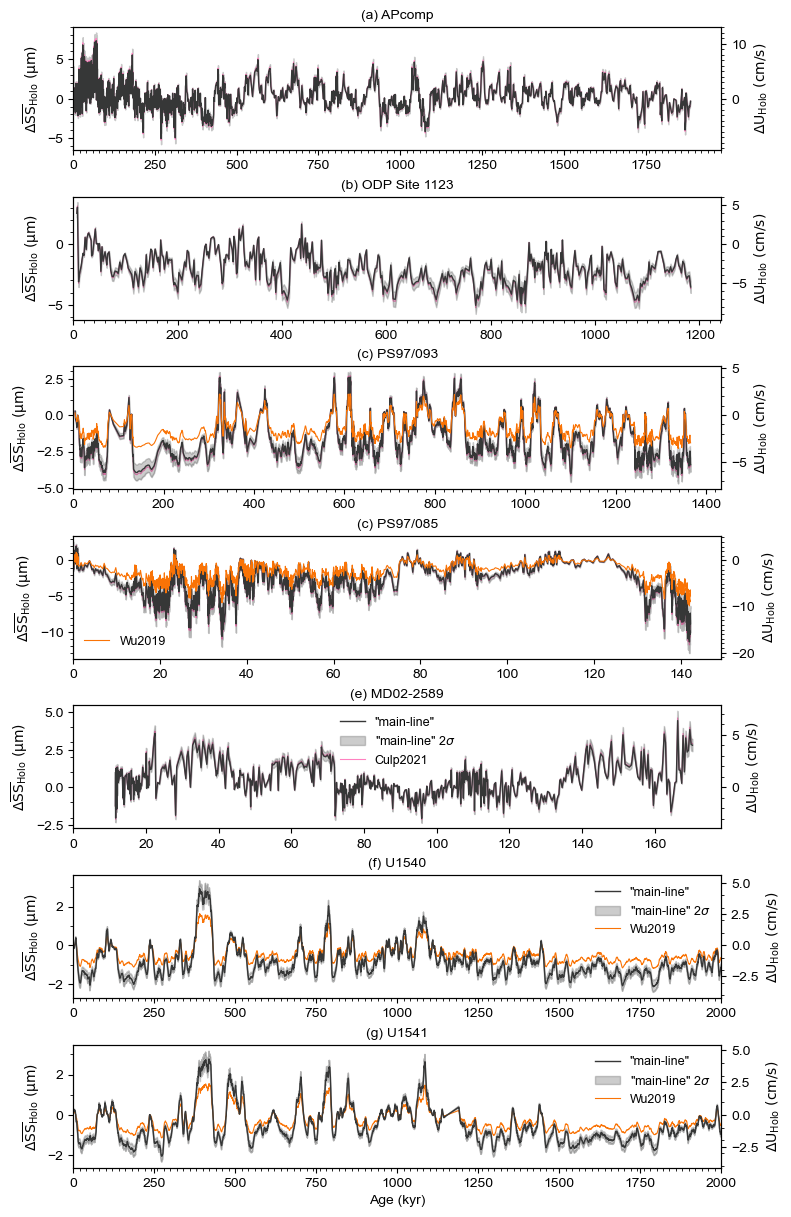

In [28]:
f,ax = plt.subplots(7,1,sharex=False,figsize=(7,14))
plt.subplots_adjust(hspace=0.4)
## Apcomp
n = apcomp['SS_dHolocene'].notnull()
ax[0].plot(apcomp['LR04_age'][n],apcomp['SS_dHolocene'][n],color='k',alpha=0.02,lw=1)
ax0 = ax[0].twinx()
ax0.plot(apcomp['LR04_age'][n],apcomp['dU_dhol_mccave'][n],color='xkcd:dark grey',lw=1,label='"main-line"')
ax0.fill_between(apcomp['LR04_age'][n],apcomp['dU_dhol_mccave'][n]-apcomp['dU_dhol_mccave_2std'][n],apcomp['dU_dhol_mccave'][n]+apcomp['dU_dhol_mccave_2std'][n],color='xkcd:dark grey',alpha=0.25)
ax0.plot(apcomp['LR04_age'][n],apcomp['dU_dhol_culp'][n],color='xkcd:pink',lw=0.8,zorder=1,label='Culp2021')

## ODP1123
n = odp1123_ss['SS_dHolocene'].notnull()
ax[1].plot(odp1123_ss['LR04 Age (Elderfield 2012)'][n],odp1123_ss['SS_dHolocene'][n],color='k',alpha=0.02,lw=1)
ax1 = ax[1].twinx()
ax1.plot(odp1123_ss['LR04 Age (Elderfield 2012)'][n],odp1123_ss['dU_dhol_mccave'][n],color='xkcd:dark grey',lw=1,label='"main-line"')
ax1.fill_between(odp1123_ss['LR04 Age (Elderfield 2012)'][n],odp1123_ss['dU_dhol_mccave'][n]-odp1123_ss['dU_dhol_mccave_2std'][n],odp1123_ss['dU_dhol_mccave'][n]+odp1123_ss['dU_dhol_mccave_2std'][n],color='xkcd:dark grey',alpha=0.25)
ax1.plot(odp1123_ss['LR04 Age (Elderfield 2012)'][n],odp1123_ss['dU_dhol_culp'][n],color='xkcd:pink',lw=0.8,zorder=-1,label='Culp2021')

## ps97
ax[2].plot(ps97_093_ss['Revised Age (Starr)'],ps97_093_ss['SS_dHolocene'],color='k',alpha=0.1,lw=1)
ax2 = ax[2].twinx()
ax2.plot(ps97_093_ss['Revised Age (Starr)'],ps97_093_ss['dU_dhol_mccave'],color='xkcd:dark grey',lw=1,label='main-line')
ax2.fill_between(ps97_093_ss['Revised Age (Starr)'],ps97_093_ss['dU_dhol_mccave']-ps97_093_ss['dU_dhol_mccave_2std'],ps97_093_ss['dU_dhol_mccave']+ps97_093_ss['dU_dhol_mccave_2std'],color='xkcd:dark grey',alpha=0.25)
ax2.plot(ps97_093_ss['Revised Age (Starr)'],ps97_093_ss['dU_dhol_culp'],lw=0.8,color='xkcd:pink',zorder=-1)
ax2.plot(ps97_093_ss['Revised Age (Starr)'],ps97_093_ss['dU_dhol_wu'],color='xkcd:orange',lw=0.8,label='main-line')


## ps97_085
ax[3].plot(ps97_085_ss['Age [ka BP]'],ps97_085_ss['SS_dHolocene'],color='k',alpha=0.1,lw=1)
ax3 = ax[3].twinx()
ax3.plot(ps97_085_ss['Age [ka BP]'],ps97_085_ss['dU_dhol_mccave'],color='xkcd:dark grey',lw=1)
ax3.fill_between(ps97_085_ss['Age [ka BP]'],ps97_085_ss['dU_dhol_mccave']-ps97_085_ss['dU_dhol_mccave_2std'],ps97_085_ss['dU_dhol_mccave']+ps97_085_ss['dU_dhol_mccave_2std'],color='xkcd:dark grey',alpha=0.25)
ax3.plot(ps97_085_ss['Age [ka BP]'],ps97_085_ss['dU_dhol_culp'],color='xkcd:pink',lw=0.8,zorder=-1)
ax3.plot(ps97_085_ss['Age [ka BP]'],ps97_085_ss['dU_dhol_wu'],color='xkcd:orange',lw=0.8, label='Wu2019',linestyle='-')
ax3.legend(frameon=False,fontsize=9)

## ps97_085
n = md02_2589['SS_dHolocene'].notnull()
ax[4].plot(md02_2589['Age [kyr]'][n],md02_2589['SS_dHolocene'][n],color='k',alpha=0.1,lw=1)
ax4 = ax[4].twinx()
ax4.plot(md02_2589['Age [kyr]'][n],md02_2589['dU_dhol_mccave'][n],color='xkcd:dark grey',lw=1,label='"main-line"')
ax4.fill_between(md02_2589['Age [kyr]'][n],md02_2589['dU_dhol_mccave'][n]-md02_2589['dU_dhol_mccave_2std'][n],md02_2589['dU_dhol_mccave'][n]+md02_2589['dU_dhol_mccave_2std'][n],color='xkcd:dark grey',alpha=0.25,label='"main-line" 2$\sigma$')
ax4.plot(md02_2589['Age [kyr]'][n],md02_2589['dU_dhol_culp'][n],color='xkcd:pink',lw=0.8,zorder=-1,label='Culp2021')
ax4.legend(frameon=False,fontsize=9)

## u1540
n = u1540['SS_dHolocene'].notnull()
ax[5].plot(u1540['Age [ka BP]'][n],u1540['SS_dHolocene'][n],color='k',alpha=0.1,lw=1)
ax5 = ax[5].twinx()
ax5.plot(u1540['Age [ka BP]'][n],u1540['dU_dhol_mccave'][n],color='xkcd:dark grey',lw=1,label='"main-line"')
ax5.fill_between(u1540['Age [ka BP]'][n],u1540['dU_dhol_mccave'][n]-u1540['dU_dhol_mccave_2std'][n],u1540['dU_dhol_mccave'][n]+u1540['dU_dhol_mccave_2std'][n],color='xkcd:dark grey',alpha=0.25,label='"main-line" 2$\sigma$')
ax5.plot(u1540['Age [ka BP]'][n],u1540['dU_dhol_wu'][n],color='xkcd:orange',lw=0.8,zorder=-1,label='Wu2019')
ax5.legend(frameon=False,fontsize=9)

## u1541
n = u1541['SS_dHolocene'].notnull()
ax[6].plot(u1541['Age [ka BP]'][n],u1541['SS_dHolocene'][n],color='k',alpha=0.1,lw=1)
ax6 = ax[6].twinx()
ax6.plot(u1541['Age [ka BP]'][n],u1541['dU_dhol_mccave'][n],color='xkcd:dark grey',lw=1,label='"main-line"')
ax6.fill_between(u1541['Age [ka BP]'][n],u1541['dU_dhol_mccave'][n]-u1541['dU_dhol_mccave_2std'][n],u1541['dU_dhol_mccave'][n]+u1541['dU_dhol_mccave_2std'][n],color='xkcd:dark grey',alpha=0.25,label='"main-line" 2$\sigma$')
ax6.plot(u1541['Age [ka BP]'][n],u1541['dU_dhol_wu'][n],color='xkcd:orange',lw=0.8,zorder=-1,label='Wu2019')
ax6.legend(frameon=False,fontsize=9)

for a in [ax[5],ax5,ax[6],ax6]:
    a.set_xlim(0,2000)

for a in ax:
    al = a.get_xlim()
    a.set_xlim(0,np.max(al))
    a.xaxis.set_minor_locator(MultipleLocator(20))
    a.yaxis.set_minor_locator(MultipleLocator(1))
    a.set_ylabel('$\mathrm{\Delta \overline{SS}_{Holo}\ (\mu m)}$')
    
for a in [ax0,ax1,ax2,ax3,ax4,ax5,ax6]:
    a.yaxis.set_minor_locator(MultipleLocator(1))
    a.set_ylabel('$\mathrm{\Delta U_{Holo}\ (cm/s)}$')

# ax[3].set_xlim(0,180)
# ax[4].set_xlim(0,240)

ax[0].set_title('(a) APcomp',fontsize=10)
ax[1].set_title('(b) ODP Site 1123',fontsize=10)
ax[2].set_title('(c) PS97/093',fontsize=10)
ax[3].set_title('(c) PS97/085',fontsize=10)
ax[4].set_title('(e) MD02-2589',fontsize=10)
ax[5].set_title('(f) U1540',fontsize=10)
ax[6].set_title('(g) U1541',fontsize=10)

# ax[0].text(1600,5.5,'(a) AP$\mathbf{_{comp}}$',fontweight='bold')
# ax[1].text(1100,1.6,'(b) PS97/093',fontweight='bold')
# ax[2].text(960,1.6,'(c) ODP 1123',fontweight='bold')
# ax[3].text(137,0.8,'(d) PS97/085',fontweight='bold')
# ax[4].text(175,3.6,'(e) MD02-2589',fontweight='bold')
plt.tight_layout()
ax[-1].set_xlabel('Age (kyr)')
f.set_size_inches(8.3,12)

plt.savefig('figures/SF4_calibration.pdf',bbox_inches='tight')

In [29]:
#### save tables
apcomp.to_csv('tables/ap_comp_ss.csv')
ps97_093_ss.to_csv('tables/ps97_ss.csv')
ps97_085_ss.to_csv('tables/ps97_085_ss.csv')
md02_2589.to_csv('tables/md02_2589_ss.csv')
odp1123_ss.to_csv('tables/odp1123_ss.csv')
u1540.to_csv('tables/u1540_ss.csv')
u1541.to_csv('tables/u1541_ss.csv')

----
## Carbon isotope gradient figure


In [30]:
def filtered(x,y,highcut,tnew = [0,0]):
    """ Interpolate to linear scale and apply low-pass butterworth filter
    
   
    returns:
    x_lin -- the linear scale for the desired record
    r_filt -- the filtered RGB red record
    r_lin -- the linearly inteprolated RGB red record
    """
    fs = np.mean(np.diff(x))

    if len(tnew)>2:
        x_lin = tnew
    else:
        minx = np.min(x)+1
        maxx = np.max(x)-1
        x_lin = np.arange(minx,maxx,fs)
    f = interp1d(x,y,fill_value='extrapolate')
    y_lin = f(x_lin)
    y_filt = butter_lowpass_filter(y_lin, highcut, 1/fs, order=5)
    return x_lin, y_filt, y_lin

def butter_lowpass(highcut, fs, order=5):
    nyq = 0.5 * fs
    high = highcut/nyq
    b, a = signal.butter(order, high, btype='low',analog=False)
    return b, a

def butter_lowpass_filter(data, highcut, fs = 0.5, order=6):
    b, a = butter_lowpass(highcut, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

In [31]:
co2 = pd.read_excel('data/external_data.xlsx',sheet_name = 'CO2',header=19)
co211 = pd.read_csv('https://doi.pangaea.de/10.1594/PANGAEA.914905?format=textfile',sep='\t',header=26)
co231 = pd.read_csv('https://doi.pangaea.de/10.1594/PANGAEA.882545?format=textfile',sep='\t',header=17)

fujitemp = pd.read_excel('data/external_data.xlsx',sheet_name = 'Dome_Fuji_iso',header=13)
fujitemp['age'] = fujitemp['Age']/1000


<>:151: SyntaxWarning: invalid escape sequence '\m'
<>:152: SyntaxWarning: invalid escape sequence '\m'
<>:153: SyntaxWarning: invalid escape sequence '\m'
<>:154: SyntaxWarning: invalid escape sequence '\m'
<>:155: SyntaxWarning: invalid escape sequence '\m'
<>:151: SyntaxWarning: invalid escape sequence '\m'
<>:152: SyntaxWarning: invalid escape sequence '\m'
<>:153: SyntaxWarning: invalid escape sequence '\m'
<>:154: SyntaxWarning: invalid escape sequence '\m'
<>:155: SyntaxWarning: invalid escape sequence '\m'
/var/folders/c_/cgbnj8n943z0v0kv5qjmw2s00000gn/T/ipykernel_80862/1728152737.py:151: SyntaxWarning: invalid escape sequence '\m'
  ax_r[0].set_ylabel('$\mathrm{\delta ^{18}O\ (^o/_{oo})}$')
/var/folders/c_/cgbnj8n943z0v0kv5qjmw2s00000gn/T/ipykernel_80862/1728152737.py:152: SyntaxWarning: invalid escape sequence '\m'
  ax_l[1].set_ylabel('$\mathrm{\delta ^{13}C\ (^o/_{oo})}$')
/var/folders/c_/cgbnj8n943z0v0kv5qjmw2s00000gn/T/ipykernel_80862/1728152737.py:153: SyntaxWarning: inv

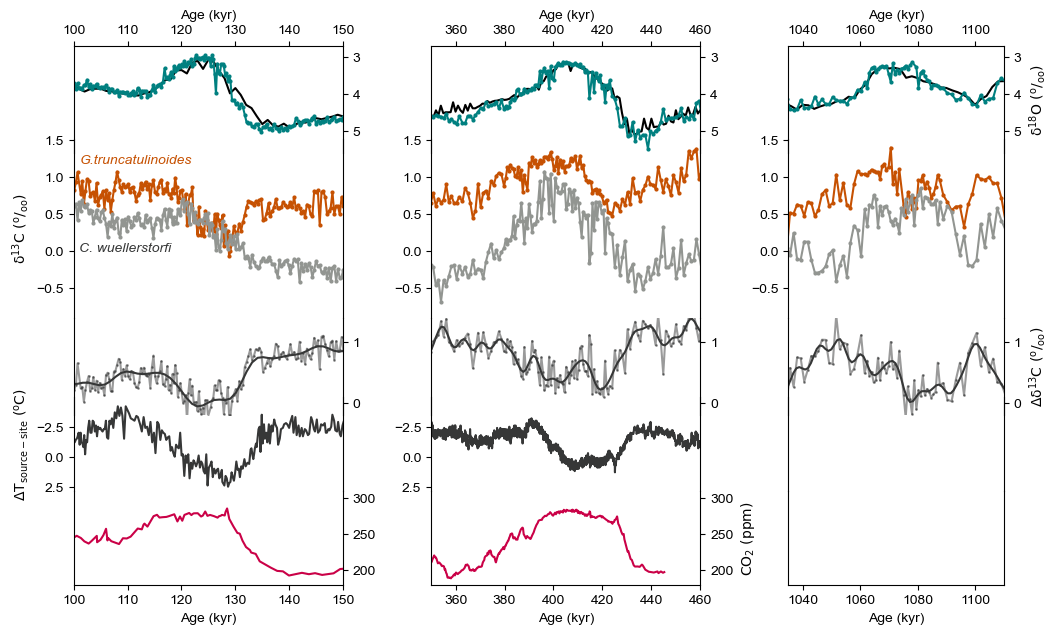

In [32]:
### PLOT ###
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams['font.size'] = 10
mpl.rcParams["mathtext.fontset"] = "dejavusans"
mpl.rcParams['font.size'] = 10

c2 = '#023e8a'
c3 = '#0077b6'
c1 = '#4a4e69'
c3 = 'xkcd:denim'
c4 = c1



c1 = '#89023e'
c4 = '#a6808c'


f = plt.figure(figsize=(12,7))
gs = gridspec.GridSpec(5,3,wspace=0.35,hspace=0,width_ratios=[1,1,0.8],height_ratios=[1,1.75,1,1,1])

ax_l = {}
ax_m = {}
ax_r = {}

ax_l[0] = f.add_subplot(gs[0,0])
ax_m[0] = f.add_subplot(gs[0,1])
ax_r[0] = f.add_subplot(gs[0,2])

for i in range(1,5):
    ax_l[i] = f.add_subplot(gs[i,0])
    ax_m[i] = f.add_subplot(gs[i,1])
    ax_r[i] = f.add_subplot(gs[i,2])



    
    
###### constant
for ax in [ax_l,ax_m,ax_r]:    

    ax[0].plot(prob[0],prob[1],label='Prob-Stack',color='k',lw=1.5)
    n = apcomp['Cwu d18O (VPDB)'].notnull()
    ax[0].plot(apcomp['LR04_age'][n],apcomp['Cwu d18O (VPDB)'][n]+0.43,label='APcomp',color='teal',marker='o',ms=2,lw=1.5)
    ax[0].invert_yaxis()
    
    ### ---- isotopes ---- ###
    y = apcomp['Gtrunc d13C (VPDB)'] 
    x = apcomp['LR04_age']
    n = y.notnull()
    x=x[n]
    y=y[n]
    ax[1].plot(x,y,marker='o',ms=2,color='xkcd:dark orange',alpha=1)

    y = apcomp['Cwu d13C (VPDB)'] 
    x = apcomp['LR04_age']
    n = y.notnull()
    x=x[n]
    y=y[n]
    ax[1].plot(x,y,marker='o',ms=2,color='xkcd:grey',alpha=1)

    
    
    
    y = apcomp['Gtrunc d13C (VPDB)'] - apcomp['Cwu d13C (VPDB)'] 
    x = apcomp['LR04_age']
    n = y.notnull()
    x=x[n]
    y=y[n]
    ax[2].plot(x,y,marker='o',ms=1,color='xkcd:dark grey',alpha=0.5)
    t,y,pp = filtered(x,y,1/7)
    ax[2].plot(t,y,lw=1.5,color='xkcd:dark grey',marker='o',ms=0)
    ax[2].set_ylim(-0.2,1.4)
    
    x = fujitemp['age']
    y = fujitemp['T_site']-fujitemp['T_source']
    n = y.notnull()
    x=x[n]
    y=y[n]
    ax[3].plot(x,y,color='xkcd:dark grey')
    # t,y,pp = filtered(x,y,1/7)
    # ax[5].plot(t,y,lw=1.5,color='xkcd:dark grey')
    ax[3].invert_yaxis()
    
    
x = co211['Age [ka BP]']
y = co211['CO2 [ppmv]']
ax_m[4].plot(x,y,color='xkcd:ruby',lw=1.5)


x = co2['age_gas_calBP']/1000
y = co2['co2_ppm']
ax_l[4].plot(x,y,color='xkcd:ruby',lw=1.5)
 
#### ----format--- ####
for ax in [ax_l,ax_m,ax_r]:    
    for i in range(0,5):
        ax[i].patch.set_visible(False)
        if i != 0:
            ax[i].spines['top'].set_visible(False)
        elif i != 4:
            ax[i].spines['bottom'].set_visible(False)
        if i==0:
            ax[i].xaxis.set_ticks_position('top')
    for i in range(1,4):
        ax[i].set_xticks([])
        ax[i].spines['bottom'].set_visible(False)
        ax[i].spines['top'].set_visible(False)


    for i in np.arange(0,5,2):
        ax[i].yaxis.set_ticks_position('right')
        ax[i].yaxis.set_label_position('right')
        
        
for i in range(0,5):
    ax_l[i].set_xlim(100,150)
    ax_m[i].set_xlim(350,460)
    ax_r[i].set_xlim(1035,1110)
    
    
for ax in [ax_l,ax_m,ax_r]:
    box = ax[0].get_position()
    box.y0 = box.y0 - 0.02
    ax[0].set_position(box)
    
    box = ax[2].get_position()
    box.y1 = box.y1 - 0.02
    box.y0 = box.y0 - 0.025
    ax[2].set_position(box)
    
    box = ax[1].get_position()
    box.y0 = box.y0 - 0.02
    ax[1].set_position(box)
    
    ax[0].set_xlabel('Age (kyr)')
    ax[0].xaxis.set_label_position('top')
    ax[4].set_xlabel('Age (kyr)')

    

ax_m[4].set_ylim(180,310)
ax_l[4].set_ylim(180,310)
ax_r[4].set_yticks([])
ax_r[3].set_yticks([])

ax_l[1].text(101,1.18,'G.truncatulinoides',style='italic',color='xkcd:dark orange')
ax_l[1].text(101,0,'C. wuellerstorfi',style='italic',color='xkcd:dark grey')

ax_r[0].set_ylabel('$\mathrm{\delta ^{18}O\ (^o/_{oo})}$')
ax_l[1].set_ylabel('$\mathrm{\delta ^{13}C\ (^o/_{oo})}$')
ax_r[2].set_ylabel('$\mathrm{\Delta \delta ^{13}C\ (^o/_{oo})}$')
ax_l[3].set_ylabel('$\mathrm{\Delta T_{source-site}\ (^oC)}$')
ax_m[4].set_ylabel('$\mathrm{CO_2\ (ppm)}$')

plt.savefig('figures/SF5_stable_isotopes.pdf',bbox_inches='tight')